# Extra installs

In [2]:
#!pip install cloud-tpu-client==0.10 torch==1.13.0 https://storage.googleapis.com/tpu-pytorch/wheels/colab/torch_xla-1.13-cp38-cp38-linux_x86_64.whl
!pip install torchsummary
!pip install sparse

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.0/81.0 KB 2.7 MB/s eta 0:00:00


# Imports

In [3]:
import os
import time
import torch.nn as nn
from tqdm import tqdm
import pyarrow.parquet as pq
from collections import defaultdict, Counter
import numpy as np
import matplotlib.pyplot as plt
import torch
import sparse
import torchvision
from torchvision.datasets.folder import DatasetFolder
# imports the torch_xla package
from sklearn.metrics import roc_auc_score
import torch.nn.functional as F
from torchsummary import summary
import torch.optim as pt_optim
import torch.optim.lr_scheduler as pt_lr_scheduler
from tqdm import tqdm

# Dataset

In [4]:
try:
  import google.colab
  COLAB_ENV = True
except:
  COLAB_ENV = False


if COLAB_ENV:
  data_filepath = "/" + os.path.join("content","drive","MyDrive","datasets", "ML4SCI_GSOC23")
  from google.colab import drive
  drive.mount('/content/drive')
else:
  data_filepath = "data"

Mounted at /content/drive


In [5]:
!ls /content/drive/MyDrive/datasets/ML4SCI_GSOC23/Task2

Task2_large.zip  Task2.zip


In [6]:
!rsync -P /content/drive/MyDrive/datasets/ML4SCI_GSOC23/Task2/Task2_large.zip .

Task2_large.zip
    511,755,972 100%  101.71MB/s    0:00:04 (xfr#1, to-chk=0/1)


In [10]:
!unzip -q Task2_large.zip

In [11]:
!ls data/Task2

Gluon  Quark


In [12]:
np_images_filepath = os.path.join("data", "Task2")
class_to_label = {0 : "Gluon",
                  1 : "Quark"}

model_save_folder = os.path.join(data_filepath, "models", "Task2")

os.makedirs(model_save_folder, exist_ok=True)
print(os.listdir(np_images_filepath))

['Quark', 'Gluon']


# EDA

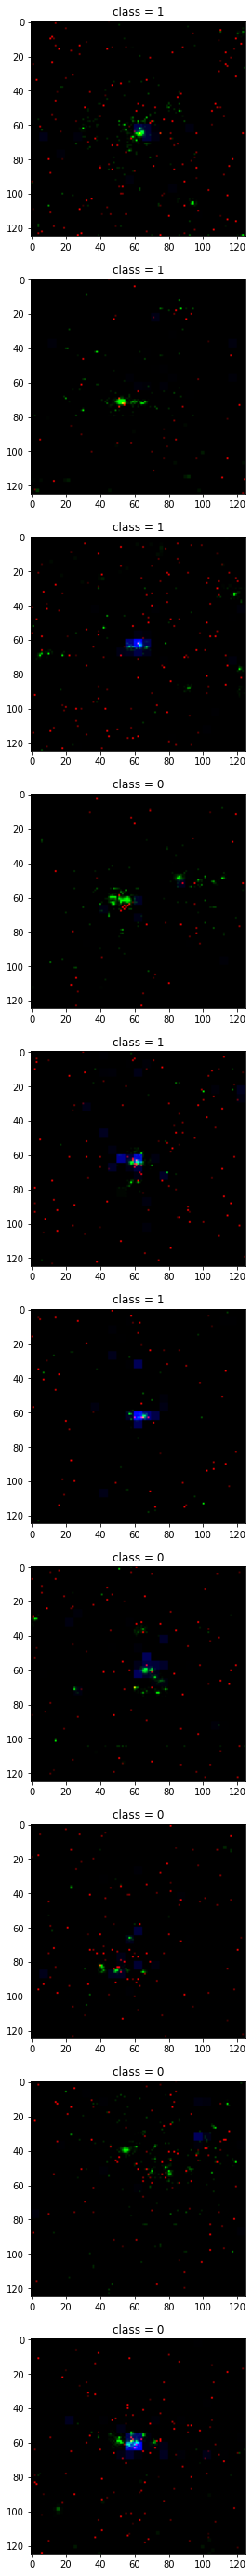

In [13]:
def get_n_random_from_class(_class : int, n : int) -> list:
  class_filepath = os.path.join(np_images_filepath, class_to_label[_class])
  files = [os.path.join(class_filepath, f) for f in os.listdir(class_filepath)]
  idxes = np.random.permutation(np.arange(0, len(files)))[:n]

  return [(_class, files[i]) for i in idxes]

gluons = get_n_random_from_class(0, 5)
quarks = get_n_random_from_class(1, 5)

to_viz = gluons + quarks
np.random.shuffle(to_viz)

scale = 5
n = len(to_viz)
plt.figure(figsize=(scale, n* scale))
for i, datapoint in enumerate(to_viz):
  cls = datapoint[0]
  #print(datapoint[1])
  img = sparse.load_npz(datapoint[1]).todense()
  plt.subplot(n, 1, i + 1)
  plt.imshow(img)
  plt.title(f"class = {cls}")

plt.show()

# Pytorch Dataset Creation

In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Device Used : {device}")

Device Used : cuda:0


In [15]:
from torch.utils.data import DataLoader

"""
# For small dataset 
mean = np.array([0.00782386,0.00482207,0.00304506])
std = np.array([0.63704916,0.18686025,0.04598732])
"""

# Large dataset
mean = np.array([0.00793777, 0.00491434, 0.00303773])
std = np.array([1.89825445, 0.18734633, 0.04594031])

def load_npy(path : str) -> torch.Tensor:
    # load from sparse representation
    img = sparse.load_npz(path).todense()
    
    # normalize the image
    img = (img - mean) / std

    # convert to pytorch representation
    img = img.transpose(2, 0, 1)
    
    return torch.from_numpy( img )

train_ds = DatasetFolder(np_images_filepath, extensions=[".npz"], loader=load_npy)
train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)

In [16]:
next(iter(train_dl))[0].shape

torch.Size([32, 3, 125, 125])

# Test Run

In [22]:
def training_epoch(model, criterion, optimizer, scheduler, dataloader, dataset_size, saveTo, num_epochs=25):
    since = time.time()

    returnDict = {"trainingLoss" : [], "trainingAccuracy" : [], "epochs" : [], "trainingAUC" : []}
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)
        returnDict["epochs"].append(epoch)

        since2 = time.time()
        model.train()  # Set model to training mode

        running_loss = 0.0
        running_corrects = 0
        y = torch.Tensor()
        pred_y = torch.Tensor()

        i = 0
        # Iterate over data.
        for inputs, labels in tqdm(dataloader):
            i += 1
            inputs = inputs.to(device).float()
            labels = labels.to(device)
            labels = labels.long()

            y = torch.cat([y, labels.cpu()])
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # track history if only in train
            with torch.set_grad_enabled(True):
                outputs = model(inputs)
                pred_labels = (outputs >= 0.5).reshape(-1)

                #print(outputs.shape)
                loss = criterion(outputs, labels.reshape(-1, 1).to(torch.float32))

                pred_y = torch.cat([pred_y, outputs.cpu()])

                # backward + optimize only if in training phase
                loss.backward()
                optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(pred_labels == labels.data)
            
        scheduler.step()

        epoch_loss = running_loss / dataset_size
        epoch_acc = running_corrects.double() / dataset_size
        AUC_ROC = roc_auc_score(y.detach().numpy(), pred_y.detach().numpy())  

        returnDict["trainingLoss"].append(epoch_loss)
        returnDict["trainingAccuracy"].append(epoch_acc.cpu().item())
        returnDict["trainingAUC"].append(AUC_ROC)

        print(f'Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} AUC ROC : {AUC_ROC:.4f} Time taken : {round(time.time() - since2, 2)}')
        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')

    # load best model weights
    returnDict["best_model"] = model
    return returnDict


In [23]:
def plotResults(results):
    plt.figure(figsize=(16,12))
    plt.subplot(3,1, 1)
    plt.plot(results['epochs'], results['trainingLoss'], label="training Loss")
    #plt.plot(results['epochs'], results['validationLoss'], label="validation Loss")
    plt.legend()

    plt.subplot(3,1, 2)
    plt.plot(results['epochs'], results['trainingAccuracy'], label="training Accuracy")
    #plt.plot(results['epochs'], results['validationAccuracy'], label="validation Accuracy")
    plt.legend()
  
  
    plt.subplot(3,1, 3)
    plt.plot(results['epochs'], results['trainingAUC'], label="training ROC")
    #plt.plot(results['epochs'], results['validationAUC'], label="validation AUC ROC")
    #plt.plot([0, results['epochs'][-1]], [0.8, 0.8], "--", color='black')
    plt.legend()

    plt.show()

In [24]:
def doExperiment(model_ft, epochs=10, learning_rate=1e-3, plot=True, _summary=True):
  if _summary:
    print(summary(model_ft, input_size=(3, 125, 125), device="cpu"))
  
  model_ft = model_ft.to(device)
  optim = pt_optim.Adam(model_ft.parameters(), lr=learning_rate)
  lr_sched = pt_lr_scheduler.StepLR(optim, 10, 0.9)

  dats = training_epoch(model_ft, F.binary_cross_entropy, optim, lr_sched, train_dl, 
                 len(train_ds) , 
                 os.path.join(model_save_folder, "Simple.pt"), 
                 num_epochs=epochs)
  
  if plot:
    plotResults(dats)
  return dats


# Basic CNN

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 121, 121]           4,800
       BatchNorm2d-2         [-1, 64, 121, 121]             128
            Conv2d-3         [-1, 64, 117, 117]         102,400
       BatchNorm2d-4         [-1, 64, 117, 117]             128
         MaxPool2d-5           [-1, 64, 58, 58]               0
            Conv2d-6           [-1, 64, 54, 54]         102,400
       BatchNorm2d-7           [-1, 64, 54, 54]             128
            Conv2d-8           [-1, 64, 50, 50]         102,400
       BatchNorm2d-9           [-1, 64, 50, 50]             128
        MaxPool2d-10           [-1, 64, 25, 25]               0
           Conv2d-11           [-1, 64, 21, 21]         102,400
      BatchNorm2d-12           [-1, 64, 21, 21]             128
           Conv2d-13           [-1, 64, 17, 17]         102,400
      BatchNorm2d-14           [-1, 64,

100%|██████████| 4354/4354 [10:59<00:00,  6.60it/s]


Loss: 0.5708 Acc: 0.7143 AUC ROC : 0.7757 Time taken : 659.76

Epoch 1/9
----------


100%|██████████| 4354/4354 [10:48<00:00,  6.71it/s]


Loss: 0.5583 Acc: 0.7230 AUC ROC : 0.7876 Time taken : 648.88

Epoch 2/9
----------


100%|██████████| 4354/4354 [10:46<00:00,  6.73it/s]


Loss: 0.5546 Acc: 0.7251 AUC ROC : 0.7911 Time taken : 647.02

Epoch 3/9
----------


100%|██████████| 4354/4354 [10:44<00:00,  6.75it/s]


Loss: 0.5507 Acc: 0.7273 AUC ROC : 0.7946 Time taken : 645.06

Epoch 4/9
----------


100%|██████████| 4354/4354 [10:44<00:00,  6.76it/s]


Loss: 0.5479 Acc: 0.7301 AUC ROC : 0.7972 Time taken : 644.56

Epoch 5/9
----------


100%|██████████| 4354/4354 [10:45<00:00,  6.75it/s]


Loss: 0.5461 Acc: 0.7313 AUC ROC : 0.7988 Time taken : 645.62

Epoch 6/9
----------


100%|██████████| 4354/4354 [10:48<00:00,  6.71it/s]


Loss: 0.5441 Acc: 0.7329 AUC ROC : 0.8005 Time taken : 648.83

Epoch 7/9
----------


100%|██████████| 4354/4354 [10:49<00:00,  6.71it/s]


Loss: 0.5421 Acc: 0.7339 AUC ROC : 0.8024 Time taken : 649.39

Epoch 8/9
----------


100%|██████████| 4354/4354 [10:48<00:00,  6.71it/s]


Loss: 0.5402 Acc: 0.7344 AUC ROC : 0.8041 Time taken : 648.61

Epoch 9/9
----------


100%|██████████| 4354/4354 [10:48<00:00,  6.72it/s]


Loss: 0.5383 Acc: 0.7362 AUC ROC : 0.8057 Time taken : 648.42

Training complete in 108m 6s


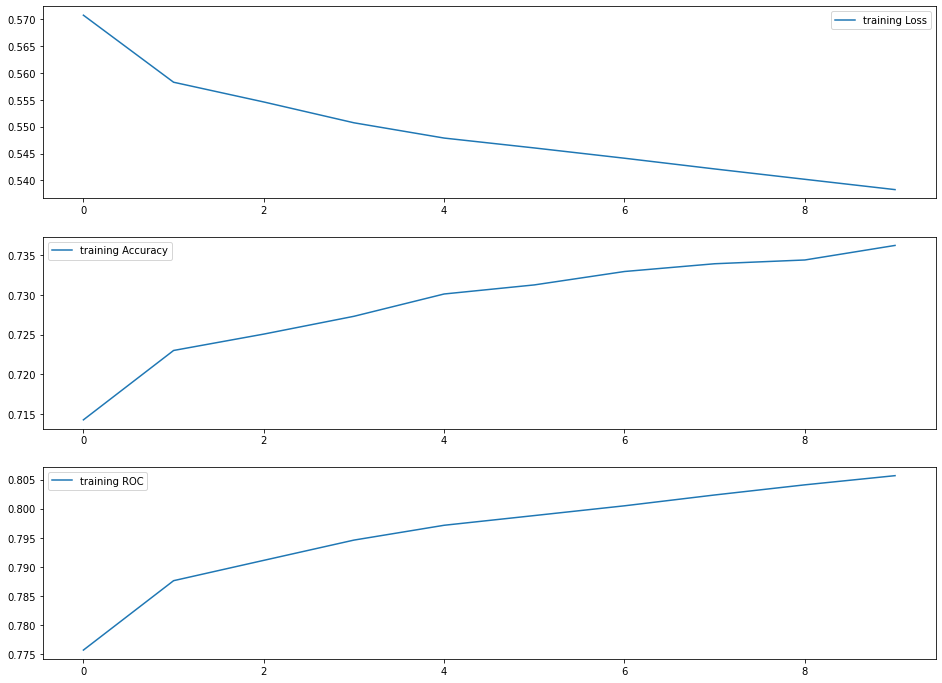

{'trainingLoss': [0.5707973253692217,
  0.5583022600323971,
  0.5546226909822509,
  0.5507420692526273,
  0.5478940853776075,
  0.5460528650958203,
  0.5441357950471064,
  0.5421375901385387,
  0.5402071731711092,
  0.5382839746104378],
 'trainingAccuracy': [0.7142836633023704,
  0.7230126484142823,
  0.7250728611832944,
  0.7273125349949033,
  0.7301193057011184,
  0.7312606779320345,
  0.7329476117324452,
  0.7339238798041722,
  0.7343976569566278,
  0.736228159591116],
 'epochs': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 'trainingAUC': [0.7756740633385086,
  0.7876186953758917,
  0.7911177106512275,
  0.794603459418491,
  0.7971552756369096,
  0.7988253671577323,
  0.8005056496685978,
  0.8023694759459644,
  0.8041152172540835,
  0.8056934822698288],
 'best_model': startingModel(
   (conv1): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), bias=False)
   (conv1_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (conv2): Conv2d(64, 64, kernel_size=(5, 5), 

In [25]:
import torch.nn as nn

class startingModel(nn.Module):
    def __init__(self):
        super(startingModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 5, bias=False)       # output becomes 26x26
        self.conv1_bn = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 64, 5, bias=False)      # output becomes 24x24
        self.conv2_bn = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(2)
      
        self.conv3 = nn.Conv2d(64, 64, 5, bias=False)      # output becomes 22x22
        self.conv3_bn = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 64, 5, bias=False)      # output becomes 20x20
        self.conv4_bn = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2)

        self.conv5 = nn.Conv2d(64, 64, 5, bias=False)      # output becomes 22x22
        self.conv5_bn = nn.BatchNorm2d(64)
        self.conv6 = nn.Conv2d(64, 64, 5, bias=False)      # output becomes 20x20
        self.conv6_bn = nn.BatchNorm2d(64)
        self.pool3 = nn.MaxPool2d(2)

        self.fc1 = nn.Linear(4096, 64, bias=False)
        self.fc2 = nn.Linear(64, 1, bias=False)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        conv1 = F.relu(self.conv1_bn(self.conv1(x)))
        conv2 = F.relu(self.conv2_bn(self.conv2(conv1)))
        conv2 = self.pool1(conv2)

        conv3 = F.relu(self.conv3_bn(self.conv3(conv2)))
        conv4 = F.relu(self.conv4_bn(self.conv4(conv3)))
        conv4 = self.pool2(conv4)

        conv5 = F.relu(self.conv5_bn(self.conv5(conv4)))
        conv6 = F.relu(self.conv6_bn(self.conv6(conv5)))
        conv6 = self.pool3(conv6)

        flat1 = torch.flatten(conv6.permute(0, 2, 3, 1), 1)
        fc1 = F.relu(self.fc1(flat1))
        logits = self.fc2(fc1)
        return self.sigmoid(logits)


doExperiment(startingModel())

## Resnet

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 63, 63]           9,408
       BatchNorm2d-2           [-1, 64, 63, 63]             128
              ReLU-3           [-1, 64, 63, 63]               0
         MaxPool2d-4           [-1, 64, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
              ReLU-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
             ReLU-10           [-1, 64, 32, 32]               0
       BasicBlock-11           [-1, 64, 32, 32]               0
           Conv2d-12           [-1, 64, 32, 32]          36,864
      BatchNorm2d-13           [-1, 64, 32, 32]             128
             ReLU-14           [-1, 64,

100%|██████████| 4354/4354 [07:46<00:00,  9.34it/s]


Loss: 0.5767 Acc: 0.7100 AUC ROC : 0.7706 Time taken : 466.31

Epoch 1/9
----------


100%|██████████| 4354/4354 [07:45<00:00,  9.36it/s]


Loss: 0.5598 Acc: 0.7209 AUC ROC : 0.7863 Time taken : 465.51

Epoch 2/9
----------


100%|██████████| 4354/4354 [07:45<00:00,  9.35it/s]


Loss: 0.5542 Acc: 0.7265 AUC ROC : 0.7913 Time taken : 465.95

Epoch 3/9
----------


100%|██████████| 4354/4354 [07:44<00:00,  9.37it/s]


Loss: 0.5504 Acc: 0.7286 AUC ROC : 0.7948 Time taken : 464.91

Epoch 4/9
----------


100%|██████████| 4354/4354 [07:45<00:00,  9.35it/s]


Loss: 0.5470 Acc: 0.7310 AUC ROC : 0.7980 Time taken : 465.82

Epoch 5/9
----------


100%|██████████| 4354/4354 [07:44<00:00,  9.36it/s]


Loss: 0.5436 Acc: 0.7333 AUC ROC : 0.8009 Time taken : 465.21

Epoch 6/9
----------


100%|██████████| 4354/4354 [07:46<00:00,  9.33it/s]


Loss: 0.5404 Acc: 0.7361 AUC ROC : 0.8037 Time taken : 467.16

Epoch 7/9
----------


100%|██████████| 4354/4354 [07:49<00:00,  9.28it/s]


Loss: 0.5371 Acc: 0.7379 AUC ROC : 0.8066 Time taken : 469.44

Epoch 8/9
----------


100%|██████████| 4354/4354 [07:49<00:00,  9.27it/s]


Loss: 0.5347 Acc: 0.7400 AUC ROC : 0.8088 Time taken : 469.99

Epoch 9/9
----------


100%|██████████| 4354/4354 [07:47<00:00,  9.31it/s]


Loss: 0.5304 Acc: 0.7426 AUC ROC : 0.8124 Time taken : 468.13

Training complete in 77m 48s


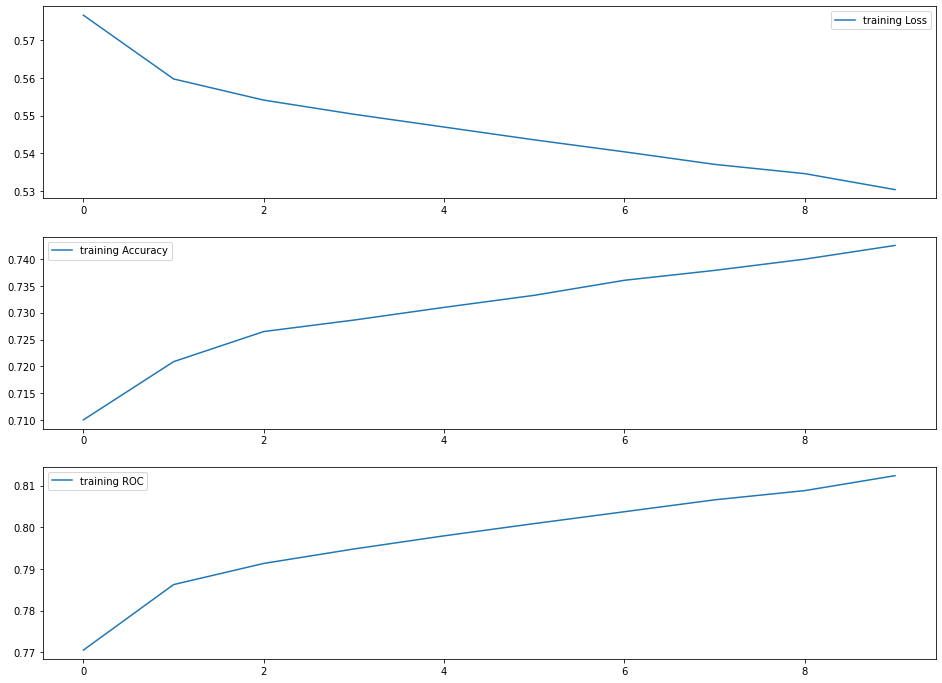

{'trainingLoss': [0.5766633521839973,
  0.559762529749101,
  0.5541523791185454,
  0.5503978975494908,
  0.5470091848040155,
  0.5436150168143036,
  0.540435780131507,
  0.5371142912288048,
  0.5346548597205901,
  0.5304204080090554],
 'trainingAccuracy': [0.7100412042553803,
  0.7208878296699353,
  0.7265013710823655,
  0.7286405467101202,
  0.7310094324723989,
  0.7332562847257118,
  0.736055876990223,
  0.7379007365081188,
  0.7399968414856504,
  0.7425523667322298],
 'epochs': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 'trainingAUC': [0.7705657100299337,
  0.7862739113588613,
  0.7913447205093659,
  0.7948134067577135,
  0.7979625424366945,
  0.8008994999385977,
  0.8037466259718831,
  0.8066002967306214,
  0.8088107811532813,
  0.812393163970862],
 'best_model': ResNet(
   (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
   (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (relu): ReLU(inplace=True)
   (maxpool): M

In [26]:
from typing import Any, Callable, List, Optional, Type, Union
from torch import Tensor


def conv3x3(in_planes: int, out_planes: int, stride: int = 1, groups: int = 1, dilation: int = 1) -> nn.Conv2d:
    """3x3 convolution with padding"""
    return nn.Conv2d(
        in_planes,
        out_planes,
        kernel_size=3,
        stride=stride,
        padding=dilation,
        groups=groups,
        bias=False,
        dilation=dilation,
    )


def conv1x1(in_planes: int, out_planes: int, stride: int = 1) -> nn.Conv2d:
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(nn.Module):
    expansion: int = 1

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        downsample: Optional[nn.Module] = None,
        groups: int = 1,
        base_width: int = 64,
        dilation: int = 1,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
    ) -> None:
        super().__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError("BasicBlock only supports groups=1 and base_width=64")
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x: Tensor) -> Tensor:
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    # Bottleneck in torchvision places the stride for downsampling at 3x3 convolution(self.conv2)
    # while original implementation places the stride at the first 1x1 convolution(self.conv1)
    # according to "Deep residual learning for image recognition" https://arxiv.org/abs/1512.03385.
    # This variant is also known as ResNet V1.5 and improves accuracy according to
    # https://ngc.nvidia.com/catalog/model-scripts/nvidia:resnet_50_v1_5_for_pytorch.

    expansion: int = 4

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        downsample: Optional[nn.Module] = None,
        groups: int = 1,
        base_width: int = 64,
        dilation: int = 1,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
    ) -> None:
        super().__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.0)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x: Tensor) -> Tensor:
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return 

class ResNet(nn.Module):
    def __init__(
        self,
        block: Type[Union[BasicBlock, Bottleneck]],
        layers: List[int],
        zero_init_residual: bool = False,
        groups: int = 1,
        width_per_group: int = 64,
        replace_stride_with_dilation: Optional[List[bool]] = None,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
    ) -> None:
        super().__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError(
                "replace_stride_with_dilation should be None "
                f"or a 3-element tuple, got {replace_stride_with_dilation}"
            )
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2, dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2, dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2, dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.logits = nn.Linear(512 * block.expansion, 1)
        self.activ_head = nn.Sigmoid()

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck) and m.bn3.weight is not None:
                    nn.init.constant_(m.bn3.weight, 0)  # type: ignore[arg-type]
                elif isinstance(m, BasicBlock) and m.bn2.weight is not None:
                    nn.init.constant_(m.bn2.weight, 0)  # type: ignore[arg-type]

    def _make_layer(
        self,
        block: Type[Union[BasicBlock, Bottleneck]],
        planes: int,
        blocks: int,
        stride: int = 1,
        dilate: bool = False,
    ) -> nn.Sequential:
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(
            block(
                self.inplanes, planes, stride, downsample, self.groups, self.base_width, previous_dilation, norm_layer
            )
        )
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(
                block(
                    self.inplanes,
                    planes,
                    groups=self.groups,
                    base_width=self.base_width,
                    dilation=self.dilation,
                    norm_layer=norm_layer,
                )
            )

        return nn.Sequential(*layers)

    def _forward_impl(self, x: Tensor) -> Tensor:
        # See note [TorchScript super()]
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.logits(x)

        return x

    def forward(self, x: Tensor) -> Tensor:
        return self.activ_head(self._forward_impl(x))


doExperiment(ResNet(BasicBlock, [2, 2, 2, 2]))